### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 1


### Дисциплина: Методы машинного обучения

##### Студент:  Матюхин Григорий Васильевич
##### Группа:   НПИбд-01-21

## Москва 2024
***

### Вариант №7

1. Набор данных: efron_morris75 
2. Независимая переменная: RemainingAverage 
3. Зависимая переменная: SeasonAverage 
4. Визуализация для независимой переменной – диаграмма размаха 
5. Визуализация для зависимой переменной – эмпирическая функция распределения 
6. Показатель качества регрессии – R^2 (коэффициент детерминации) 


# Выполнение

# Step 1: Загружаем датасет

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

2024-04-17 12:47:26.608378: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 12:47:26.811957: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-17 12:47:27.538847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 12:47:29.118328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ds = tfds.load("efron_morris75", split="train")
df = tfds.as_dataframe(ds)
len(df)

2024-04-17 12:48:02.988139: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/18 [00:00<?, ? examples/s]

Shuffling /home/gmatiukhin/tensorflow_datasets/efron_morris75/incomplete.PDR4LM_1.0.0/efron_morris75-train.tfr…

Dataset efron_morris75 downloaded and prepared to /home/gmatiukhin/tensorflow_datasets/efron_morris75/1.0.0. Subsequent calls will reuse this data.


2024-04-17 12:48:06.799926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


18

In [3]:
df.head()

,At-Bats,BattingAverage,FirstName,Hits,LastName,RemainingAt-Bats,RemainingAverage,SeasonAt-Bats,SeasonAverage,SeasonHits
0,45,0.289,b'Don',13,b'Kessinger',586,0.2645,631,0.266,168
1,45,0.178,b'Thurman',8,b'Munson',408,0.3162,453,0.302,137
2,45,0.222,b'George',10,b'Scott',435,0.3034,480,0.296,142
3,45,0.222,b'Billy',10,b'Williams',591,0.3299,636,0.251,205
4,45,0.311,b'Jim',14,b'Spencer',466,0.2704,511,0.274,140


In [4]:
df.drop(columns=["FirstName", "LastName", "At-Bats", "Hits", "SeasonAt-Bats", "SeasonHits", "RemainingAt-Bats"], inplace=True)
df.head()

,BattingAverage,RemainingAverage,SeasonAverage
0,0.289,0.2645,0.266
1,0.178,0.3162,0.302
2,0.222,0.3034,0.296
3,0.222,0.3299,0.251
4,0.311,0.2704,0.274


### Анализ датасета

In [6]:
import pandas as pd

In [96]:
corr=df.corr()
corr

,BattingAverage,RemainingAverage,SeasonAverage
BattingAverage,1.000000,0.261038,0.534403
RemainingAverage,0.261038,1.000000,0.865239
SeasonAverage,0.534403,0.865239,1.000000


In [8]:
a, b = corr.stack().idxmin()
print("Min correlation:\n", corr.loc[[a], [b]])

Min correlation:
                 RemainingAverage
BattingAverage          0.253028


In [9]:
corr = corr.stack()
corr = corr[corr != 1.0]
a, b = corr.idxmax()
print("Max correlation:\n", corr.loc[[a], [b]])

Max correlation:
 RemainingAverage  SeasonAverage    0.830656
dtype: float64


## Step 2: Visualisation

<Axes: title={'center': "Box plot for 'RemainingAverage'"}>

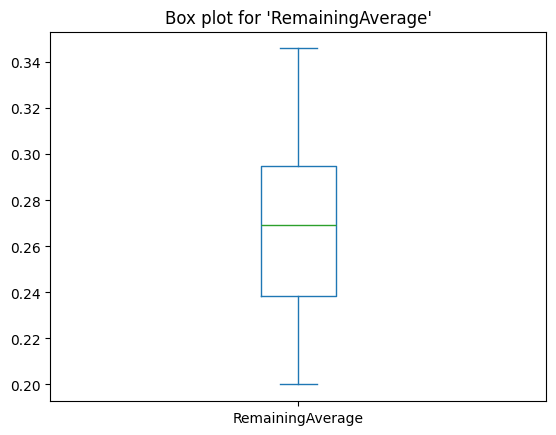

In [97]:
# Todo: not sure if a box with legent is needed here as there's only one value
df["RemainingAverage"].plot.box(title="Box plot for 'RemainingAverage'")

In [28]:
import numpy as np

<Axes: title={'center': 'ECDF'}>

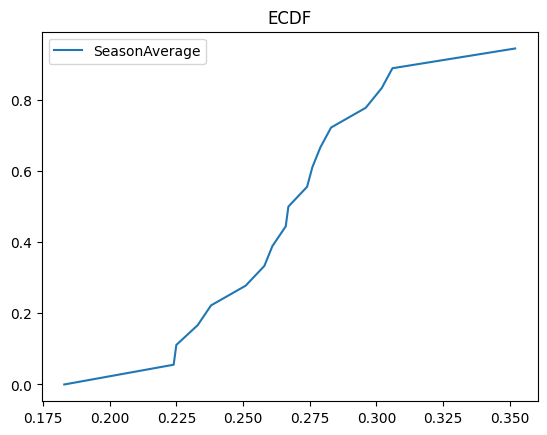

In [98]:
tx = np.sort(df["SeasonAverage"])
ty = np.arange(len(tx))/float(len(tx))
ecdf = pd.DataFrame(ty, index=tx, columns=["SeasonAverage"])
ecdf.plot.line(title="ECDF")

## Step 3: Scatter plot

<Axes: title={'center': "Scatter plot for 'RemainingAverage' and 'SeasonAverage"}, xlabel='RemainingAverage', ylabel='SeasonAverage'>

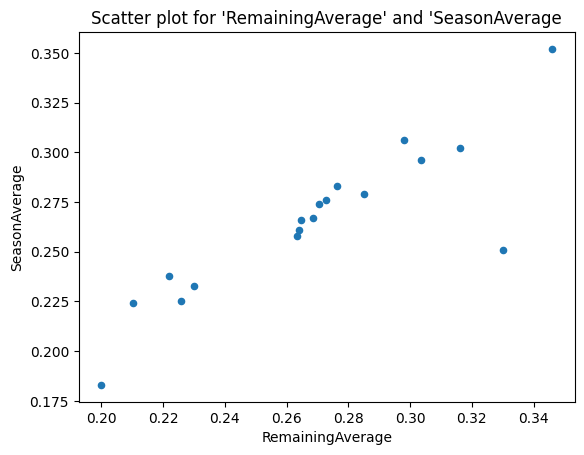

In [99]:
df.plot.scatter("RemainingAverage", "SeasonAverage", title="Scatter plot for 'RemainingAverage' and 'SeasonAverage")

## Step 4: Linear regression

### Using numerical methods (Todo: name?)

In [39]:
class SimpleLinReg:
    def __init__(self):
        self._a = None
        self._b = None
    def fit(self, x, y):
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        tx = x - x_mean
        ty = y - y_mean
        self._a = tx.dot(ty) / tx.dot(tx)
        self._b = y_mean - self._a * x_mean
        return self
    def predict(self, x_predict):
        return np.array([self._predict(x) for x in x_predict])
    def _predict(self, x_single):
        return self._a * x_single + self._b
    def __repr__(self):
        return "SimpleLinReg()"

In [95]:
x = df["RemainingAverage"]
y = df["SeasonAverage"]

In [100]:
reg = SimpleLinReg()
reg.fit(x, y)
pred = reg.predict(np.array(x))
pred

array([0.26041675, 0.302406  , 0.29201025, 0.31353277, 0.26520854,
       0.25960457, 0.27698505, 0.26707655, 0.25992945, 0.20803167,
       0.32660872, 0.26374662, 0.225737  , 0.28770572], dtype=float32)

In [46]:
import matplotlib.pyplot as plt

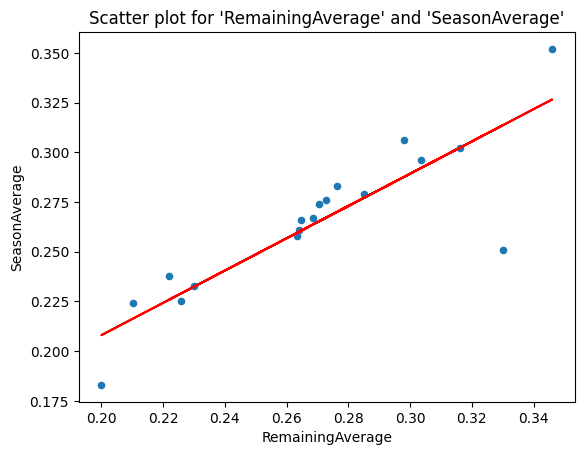

In [101]:
plt = df.plot.scatter("RemainingAverage", "SeasonAverage", title="Scatter plot for 'RemainingAverage' and 'SeasonAverage'")
plt.plot(x, pred, color="r")

In [102]:
mse = np.sum((pred - y) ** 2) / len(y)
mse

0.00042066071182489395

In [103]:
r2 = 1 - mse/np.var(y)
r2

0.6899893650279979

### Using a neuron

In [104]:
tf.__version__

'2.16.1'

In [105]:
model = tf.keras.Sequential( [tf.keras.layers.Dense(1, input_shape=(1,))])
model.summary()

/home/gmatiukhin/Study/ml-methods/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [106]:
model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.2),
    metrics=["r2_score"]
)

In [111]:
model.fit(x, y, epochs=300, verbose=0)

In [112]:
model_predict = model.predict(x)
model_predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[0.25656223],
       [0.30412364],
       [0.2923483 ],
       [0.31672695],
       [0.26198995],
       [0.2556423 ],
       [0.27532923],
       [0.26410583],
       [0.2560103 ],
       [0.19722548],
       [0.33153814],
       [0.260334  ],
       [0.21728039],
       [0.28747255]], dtype=float32)

In [113]:
loss, r2_model = model.evaluate(x_test, y_test)
r2_model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0113 - r2_score: 0.7350


0.735000491142273

In [114]:
r2, r2_model

(0.6899893650279979, 0.735000491142273)

## Step 5: Comparison on a scatter plot

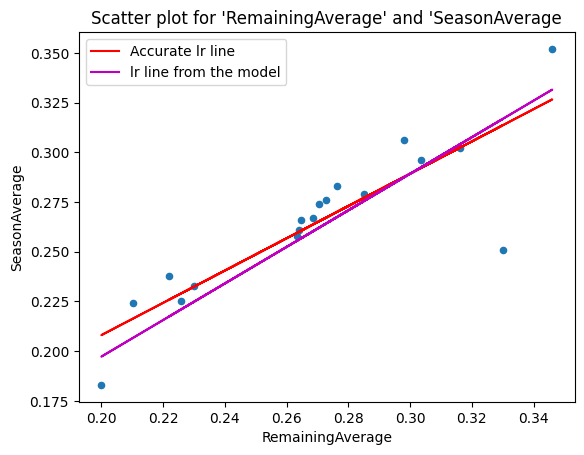

In [115]:
plt = df.plot.scatter("RemainingAverage", "SeasonAverage", title="Scatter plot for 'RemainingAverage' and 'SeasonAverage")
plt.plot(x, y_hat, color="r", label="Accurate lr line")
plt.plot(x, model_predict, color="m", label="lr line from the model")
plt.legend()

## Step 6: Splitting on 'train' and 'test'; normalizing stuff

### Splitting the dataset

In [118]:
split = 0.8
idx = int(len(df) * split)
train, test = df[:idx], df[idx:]
len(train), len(test)

(14, 4)

### "Normalize this, normalize that", how about you normalize your database!?

In [145]:
n = np.array([x for x in train if x != "SeasonAverage"])
features = train[n]
features

,BattingAverage,RemainingAverage
0,0.289,0.2645
1,0.178,0.3162
2,0.222,0.3034
3,0.222,0.3299
4,0.311,0.2704
5,0.222,0.2635
6,0.200,0.2849
7,0.311,0.2727
8,0.222,0.2639
9,0.156,0.2000


In [146]:
normalizer = tf.keras.layers.Normalization(input_shape=features.shape, axis=None)
normalizer.adapt(features)

/home/gmatiukhin/Study/ml-methods/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


UnboundLocalError: cannot access local variable 'input_shape' where it is not associated with a value

In [ ]:
print(normalizer.mean.numpy())
print(normalizer.variance.numpy())

In [ ]:
norm_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1)
])
norm_model.summary()